In [59]:
from laminar_uecog_viz import spectral
from laminar_uecog_viz import utils 
from process_nwb import resample, linenoise_notch, common_referencing, wavelet_transform
import pandas as pd
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from pynwb import NWBHDF5IO

In [2]:
# Plotting parameters
mpl.rcParams['figure.facecolor'] = '1'

# Spectral analysis
- Load data
- Preprocess (if necessary using preprocess_folder.py from process_nwb)
    - Resample down to 3200Hz
    - Notch line noise and harmonics
    - Reference CAR
    - Compute wavelet transform
    - Resample down to 400Hz
- Plot spectrogram for one channel

## User defined parameters

In [3]:
data_path = '/Users/vanessagutierrez/Desktop/NWB_Test/RVG14/RVG14_B02.nwb' #path to nwb file
io = NWBHDF5IO(data_path, 'r')
nwb = io.read()

In [4]:
nwb

root pynwb.file.NWBFile at 0x140612793399280
Fields:
  acquisition: {
    ECoG <class 'pynwb.ecephys.ElectricalSeries'>
  }
  devices: {
    ECoG <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    ECoG <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  experiment_description: This is an acute rat experiment. Auditory stimuli are played to an anesthsized rat and electrophysiological measurements are made auditory cortex
  experimenter: ['Vanessa Gutierrez']
  file_create_date: [datetime.datetime(2021, 9, 7, 14, 41, 19, 658854, tzinfo=tzoffset(None, -25200))]
  identifier: 566e7bfc-1024-11ec-8683-aa665a133c20
  institution: Lawrence Berkeley National Lab
  intervals: {
    trials <class 'pynwb.epoch.TimeIntervals'>
  }
  lab: Bouchard Lab
  notes: All channels responded, same as WN, good tone map but some broad responses, most likely due to bad channels or slight bleeding in that area (bottom left)
  pharmacology: Anest

In [5]:
nwb.acquisition

{'ECoG': ECoG pynwb.ecephys.ElectricalSeries at 0x140612793706240
 Fields:
   conversion: 1.0
   data: <HDF5 dataset "data": shape (1321710, 128), type "<f8">
   description: This is an acute rat experiment. Auditory stimuli are played to an anesthsized rat and electrophysiological measurements are made auditory cortex. Recordings from ECoG sampled at 12207.031250 Hz. Then resampled down to 12000 Hz
   electrodes: electrodes <class 'hdmf.common.table.DynamicTableRegion'>
   rate: 12000.0
   resolution: -1.0
   starting_time: 0.0
   starting_time_unit: seconds
   unit: volts}

## Preprocessed data
**If there is no preprocessed data run preprocess_folder.py as shown below**

In [6]:
#python /Users/vanessagutierrez/process_nwb/scripts/preprocess_folder /Users/vanessagutierrez/Desktop/NWB_Test/RVG16 --all_filters --acq_name ECoG

In [7]:
nwb.processing['preprocessing']

preprocessing pynwb.base.ProcessingModule at 0x140612796023472
Fields:
  data_interfaces: {
    CAR <class 'pynwb.ecephys.ElectricalSeries'>,
    CAR_ln_downsampled_ECoG <class 'pynwb.ecephys.ElectricalSeries'>,
    downsampled_ECoG <class 'pynwb.ecephys.ElectricalSeries'>,
    wvlt_amp_CAR_ln_downsampled_ECoG <class 'pynwb.misc.DecompositionSeries'>
  }
  description: Preprocessing.

In [8]:
# load wavelet data
wavelet_di = nwb.processing['preprocessing'].get_data_interface('wvlt_amp_CAR_ln_downsampled_ECoG')
Wall = wavelet_di.data
f = wavelet_di.bands.band_mean.data
fs_final = wavelet_di.rate

In [9]:
print(Wall)

<HDF5 dataset "data": shape (44057, 128, 54), type "<f4">


In [23]:
Wall.shape[2]

54

In [21]:
channel_order = [
                    81, 83, 85, 87, 89, 91, 93, 95, 97, 105, 98, 106, 114, 122, 113, 121,
                    82, 84, 86, 88, 90, 92, 94, 96, 99, 107, 100, 108, 116, 124, 115, 123,
                    66, 68, 70, 72, 74, 76, 78, 80, 101, 109, 102, 110, 118, 126, 117, 125,
                    65, 67, 69, 71, 73, 75, 77, 79, 103, 111, 104, 112, 120, 128, 119, 127,
                    63, 61, 59, 57, 55, 53, 51, 49, 25, 17, 26, 18, 10, 2, 9, 1,
                    64, 62, 60, 58, 56, 54, 52, 50, 27, 19, 28, 20, 12, 4, 11, 3,
                    48, 46, 44, 42, 40, 38, 36, 34, 29, 21, 30, 22, 14, 6, 13, 5,
                    47, 45, 43, 41, 39, 37, 35, 33, 31, 23, 32, 24, 16, 8, 15, 7
                    ]

In [20]:
def channel_orderer(signal_data, channel_order):
    """Puts the wave data into the order of the channels
    Args: 
    data: signal data in timepoints x channels
    chs (list): the correct order of the channels"""
    shape_wanted = signal_data.shape
    new_data = np.empty((shape_wanted[0], shape_wanted[1], shape_wanted[2]))
    
    for i in np.arange(shape_wanted[1]):
        new_data[:, i, :] = signal_data[:, (channel_order[i] - 1), :]
    return new_data

In [22]:
Wall_ordered = channel_orderer(Wall, channel_order)

In [25]:
Wall_ordered[:,0,:].shape

(44057, 54)

In [11]:
f

<HDF5 dataset "band_mean": shape (54,), type "<f8">

In [12]:
wavelet_di.rate

400.0

## Plot spectrogram for a 0.5 sec window

Text(27.0, 0.5, 'Frequency (Hz)')

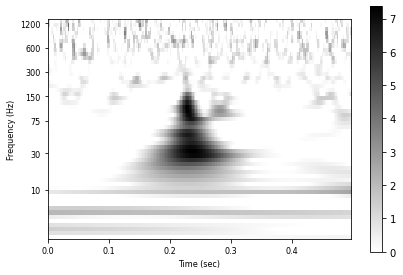

In [63]:
W = Wall[:, 0, :]
tbeg = int(fs_final*14.35)
tend = tbeg + int(fs_final*0.5)
Wsnip = W[tbeg:tend, :]
mean = np.mean(W, axis=0)
sigma = np.std(W, axis=0)
Wsnip_norm = (Wsnip - mean)/sigma
t = np.arange(0, tend-tbeg)/fs_final
fig, ax = spectral.plot_spectrogram(Wsnip_norm, np.array(f), t, colorbar=True)
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Frequency (Hz)')

In [14]:
channel_order = [
                    81, 83, 85, 87, 89, 91, 93, 95, 97, 105, 98, 106, 114, 122, 113, 121,
                    82, 84, 86, 88, 90, 92, 94, 96, 99, 107, 100, 108, 116, 124, 115, 123,
                    66, 68, 70, 72, 74, 76, 78, 80, 101, 109, 102, 110, 118, 126, 117, 125,
                    65, 67, 69, 71, 73, 75, 77, 79, 103, 111, 104, 112, 120, 128, 119, 127,
                    63, 61, 59, 57, 55, 53, 51, 49, 25, 17, 26, 18, 10, 2, 9, 1,
                    64, 62, 60, 58, 56, 54, 52, 50, 27, 19, 28, 20, 12, 4, 11, 3,
                    48, 46, 44, 42, 40, 38, 36, 34, 29, 21, 30, 22, 14, 6, 13, 5,
                    47, 45, 43, 41, 39, 37, 35, 33, 31, 23, 32, 24, 16, 8, 15, 7
                    ]

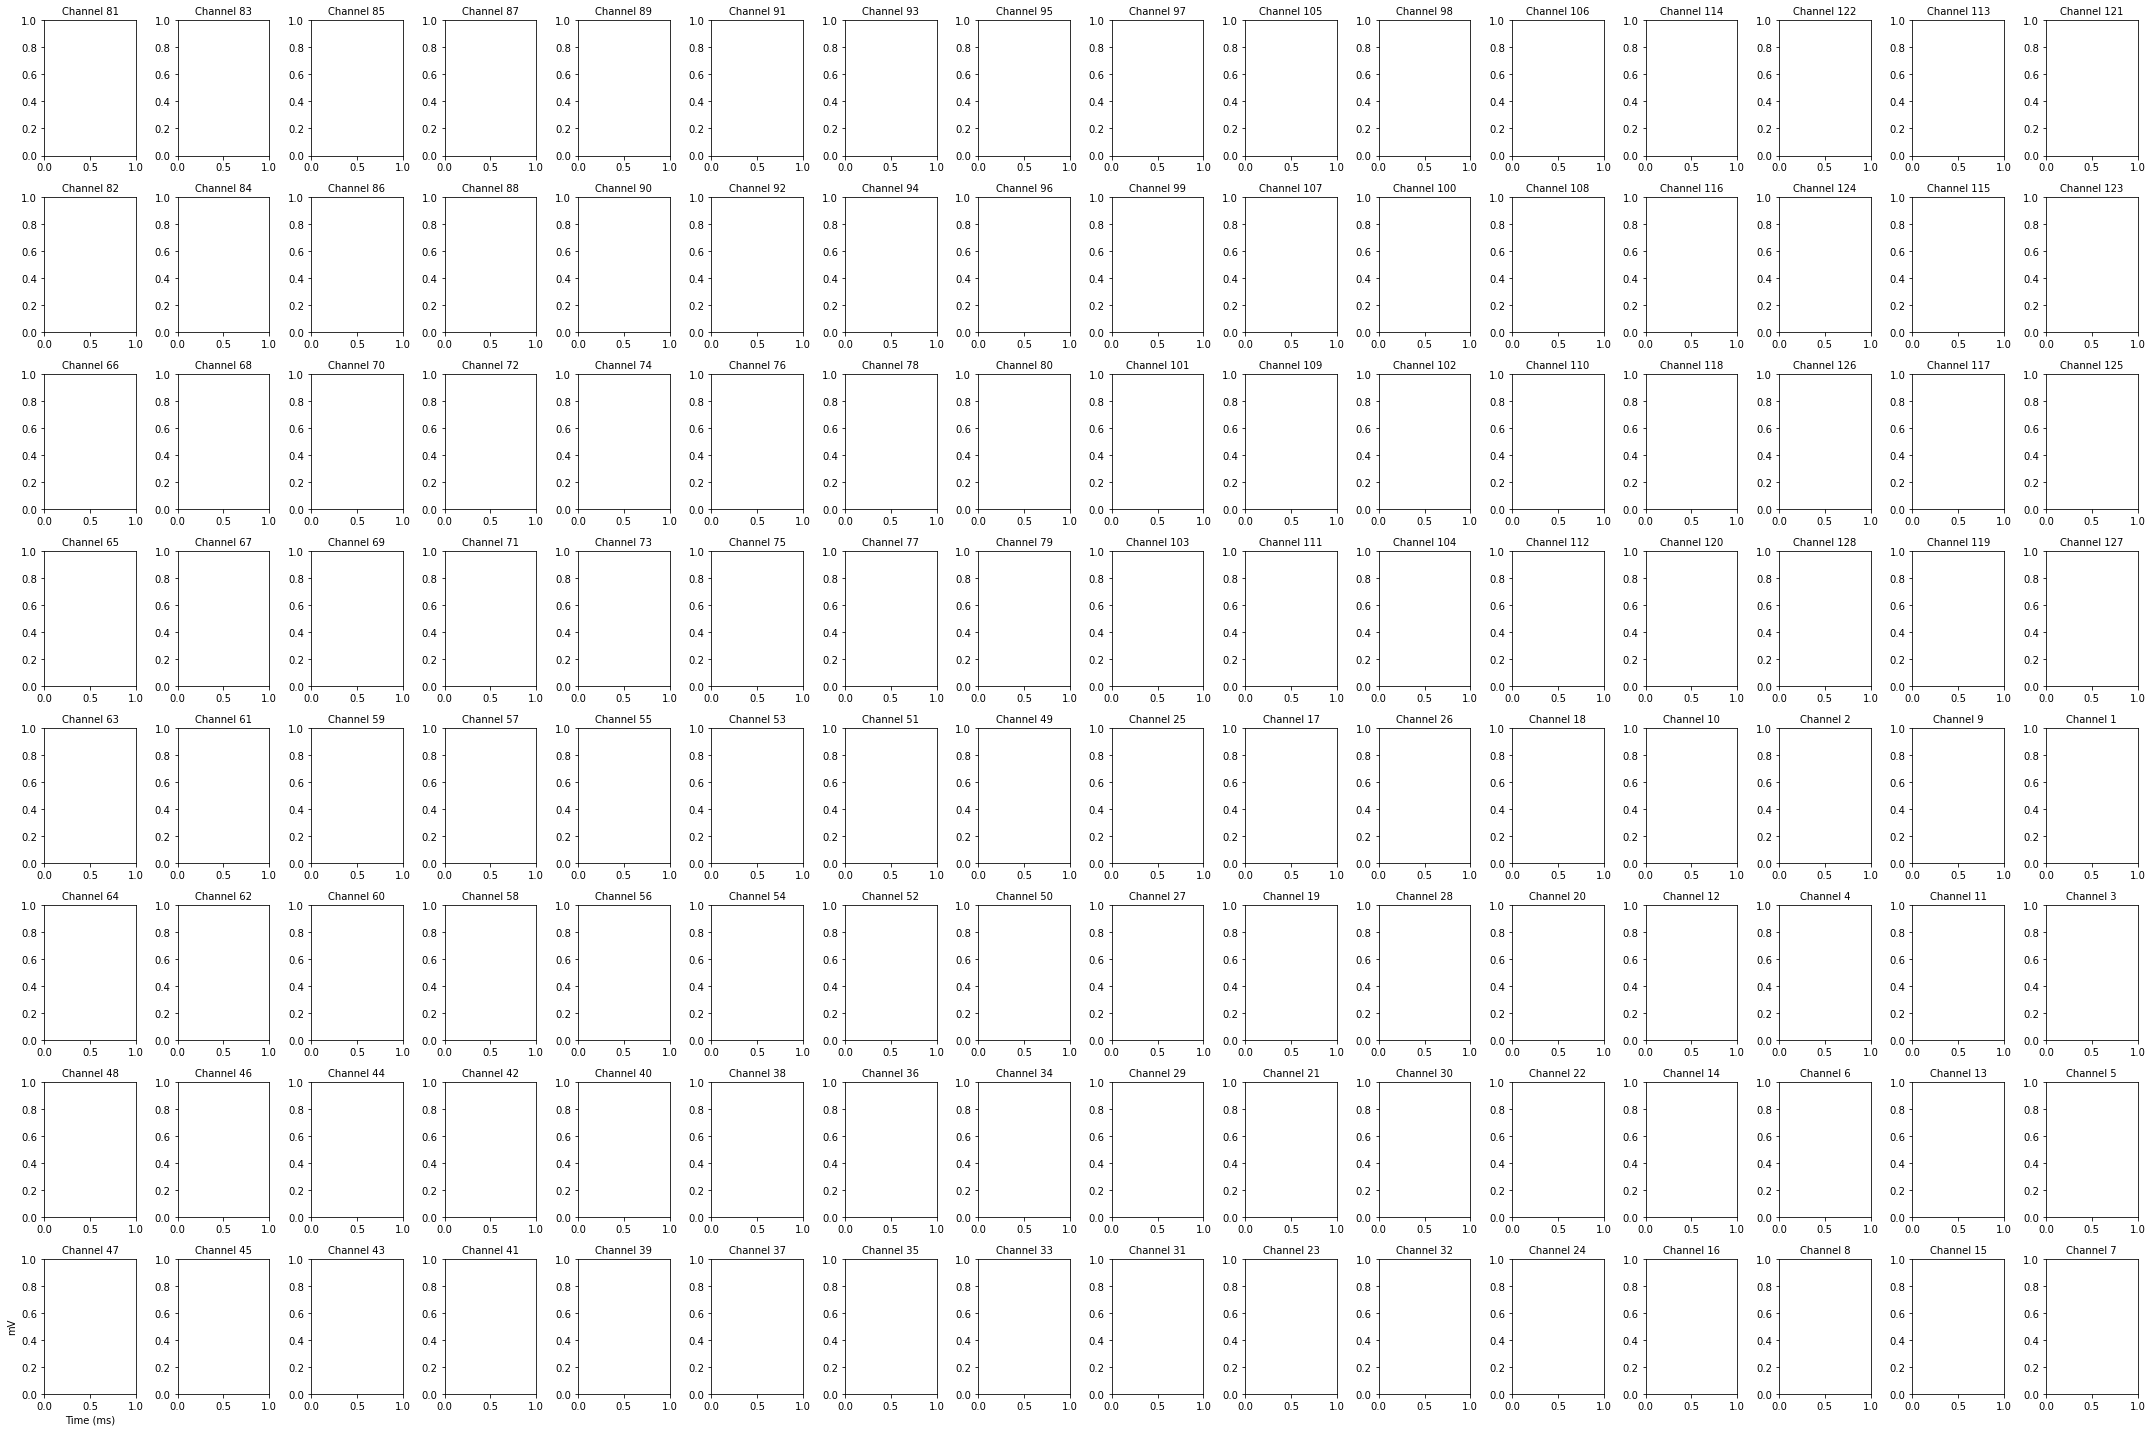

In [17]:
axes = utils.ecog_axes(channel_order, plot_type='Spectrograms')

In [64]:
def plot_channel_spect(wavelet_data, ch, fig = None, ax = None):
    
    if fig == None and ax == None:
        print('Plot:')
    else:
        fig, ax = fig, ax 
        #ax = ax 
        #fig = fig
    
    W = Wall[:, ch, :]
    
    tbeg = int(fs_final*14.35)
    tend = tbeg + int(fs_final*0.5)
    Wsnip = W[tbeg:tend, :]
    mean = np.mean(W, axis=0)
    sigma = np.std(W, axis=0)
    
    Wsnip_norm = (Wsnip - mean)/sigma
    t = np.arange(0, tend-tbeg)/fs_final
    
    spectral.plot_spectrogram(Wsnip_norm, np.array(f), t, colorbar=True)
    
    

Plot:


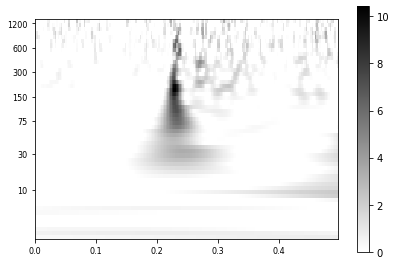

In [65]:
plot_channel_spect(Wall, 100)

In [66]:
def plot_spect_matrix(wavelet_data, channel_order):
    
    axes = utils.ecog_axes(channel_order, plot_type='Spectrograms')
    
    for ch, ax in zip(channel_order, axes):
        plot_channel_spect(wavelet_data, ch-1, fig = None, ax = ax)

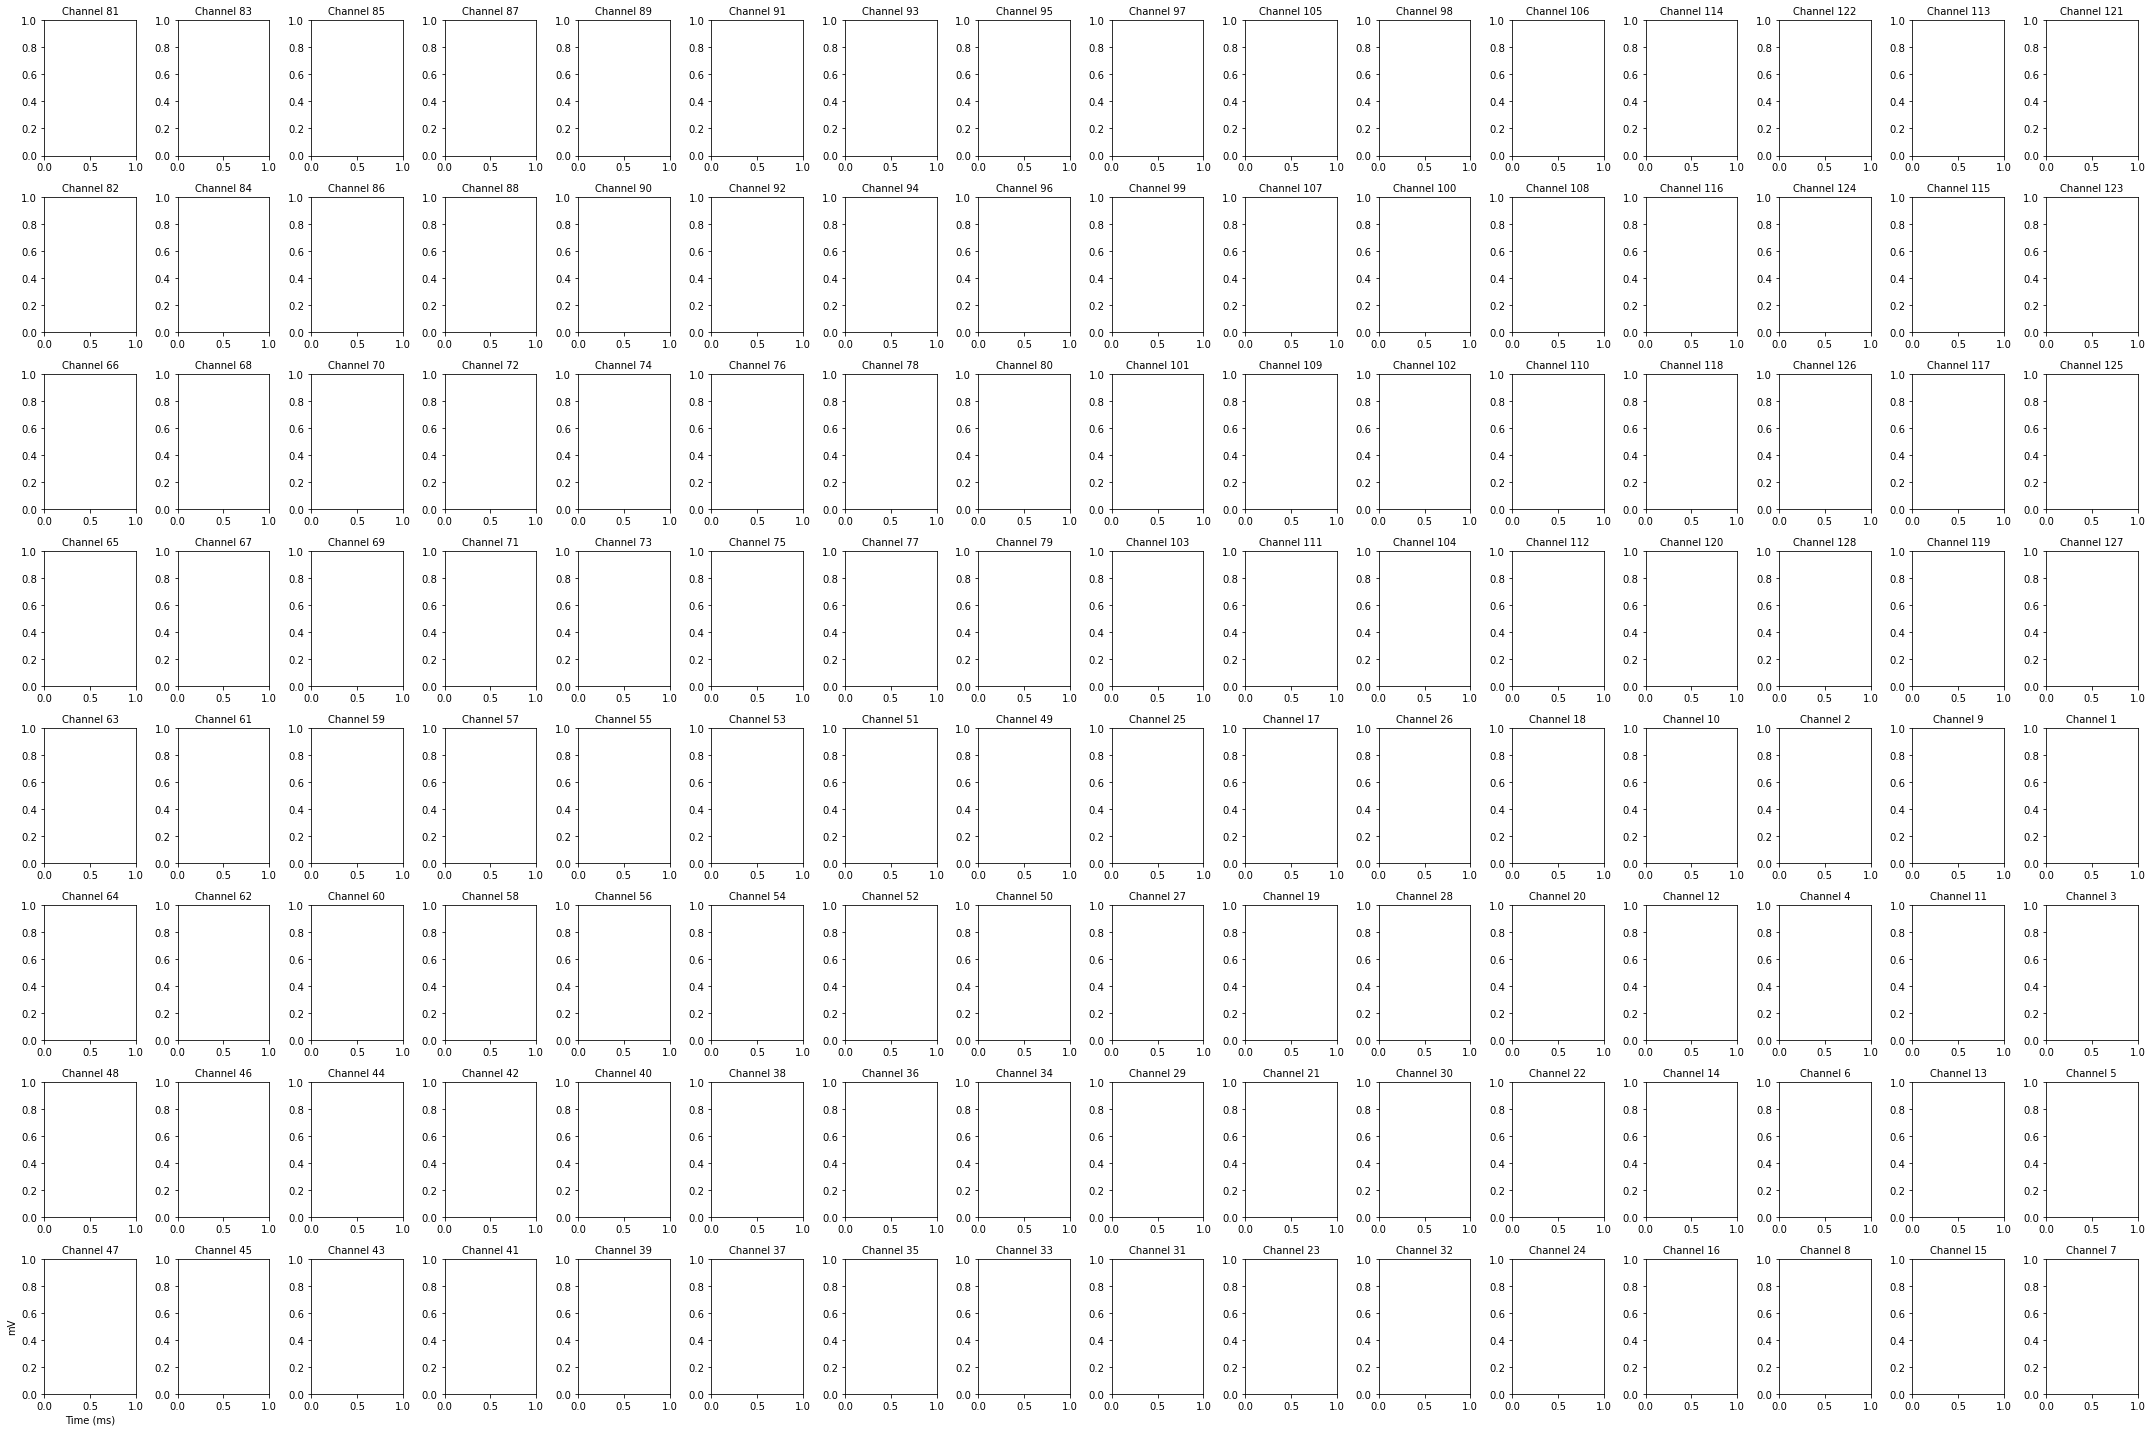

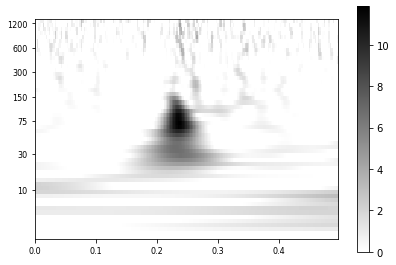

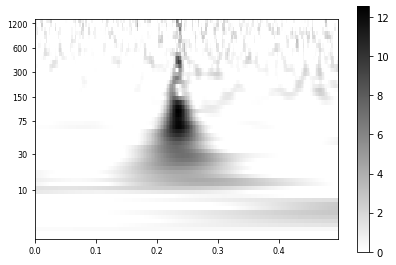

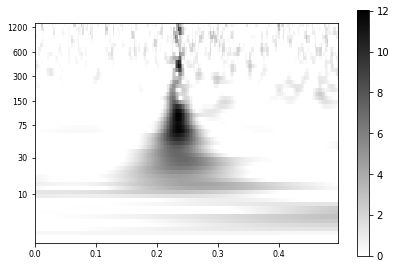

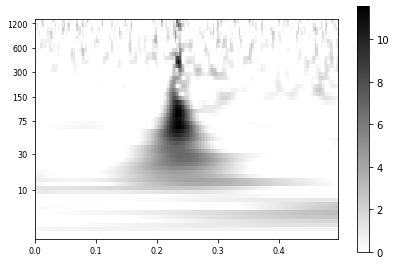

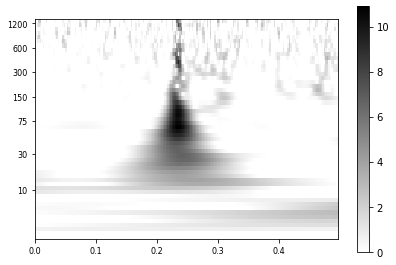

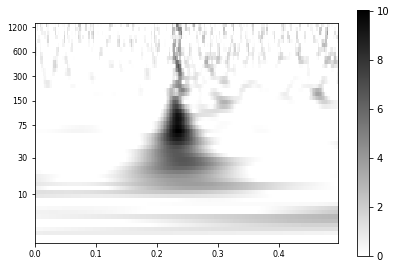

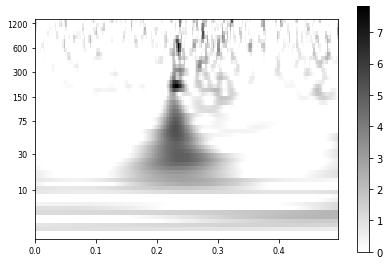

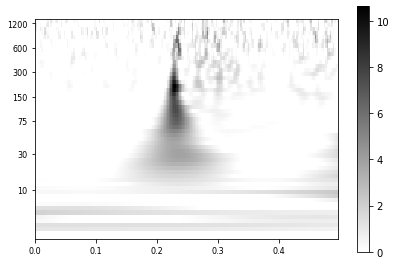

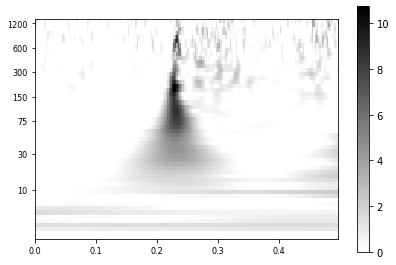

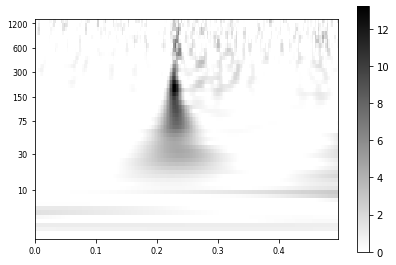

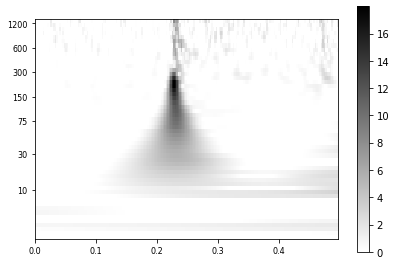

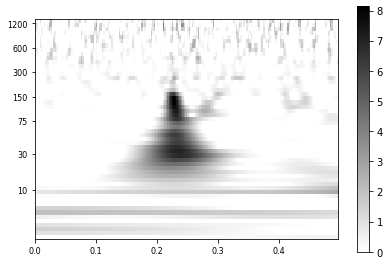

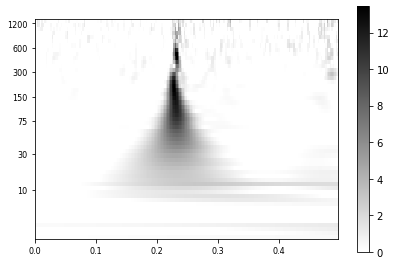

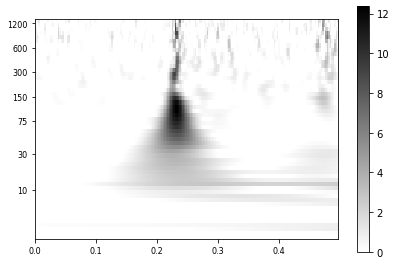

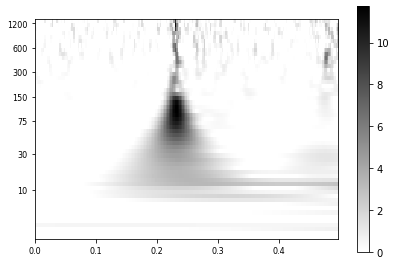

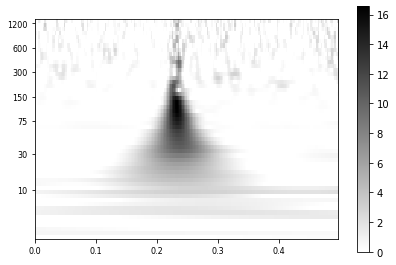

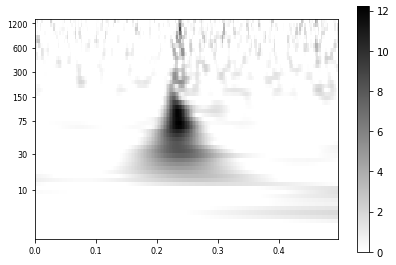

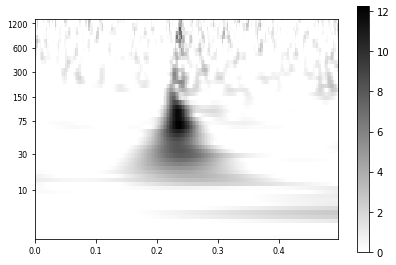

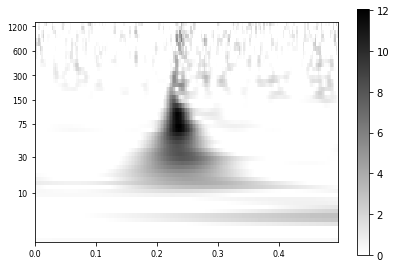

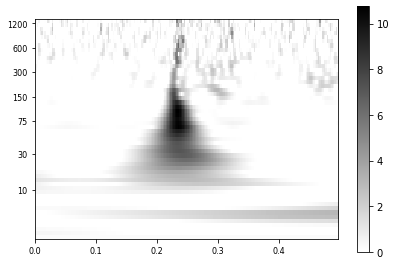

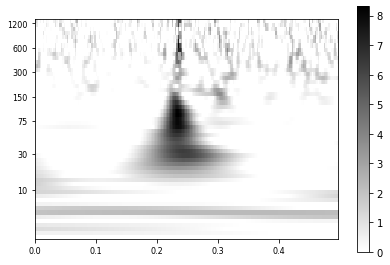

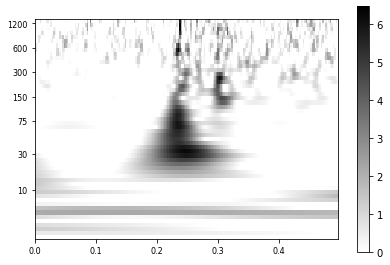

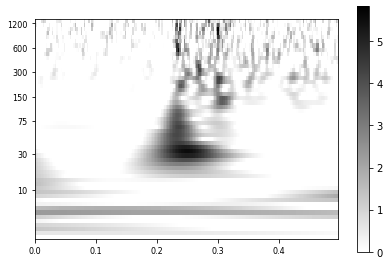

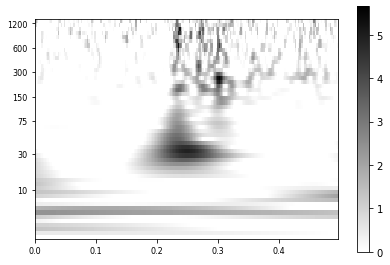

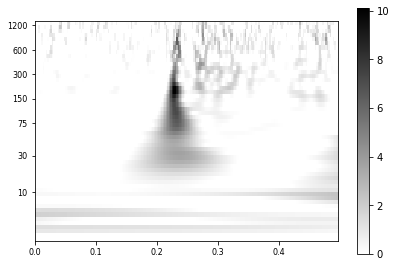

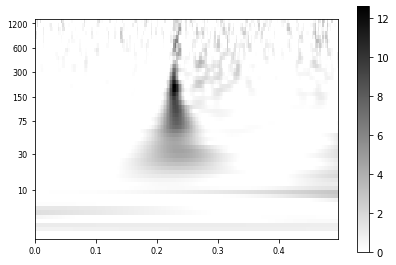

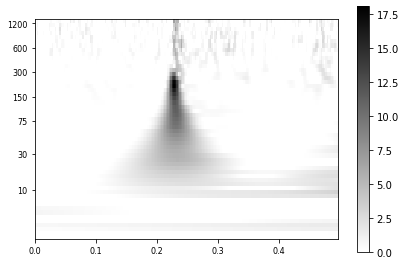

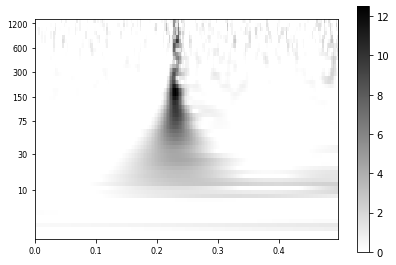

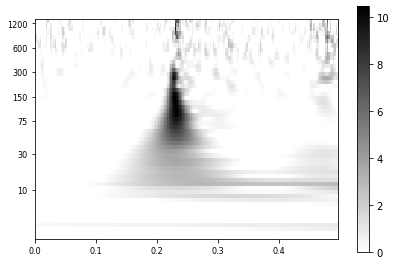

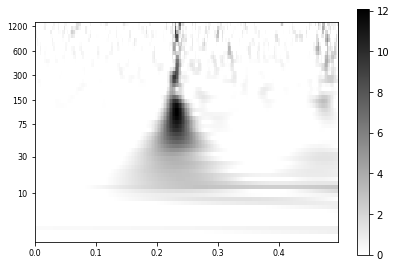

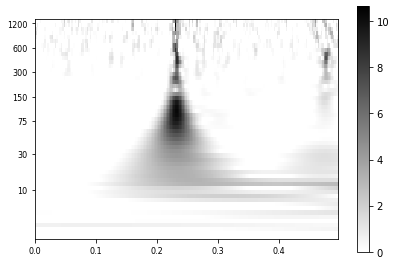

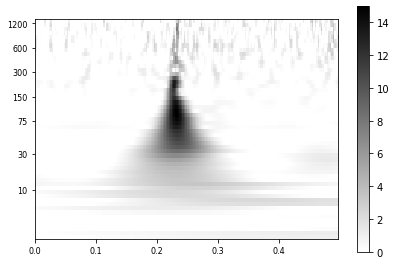

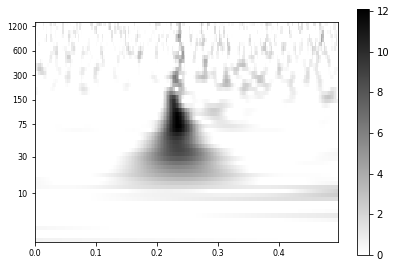

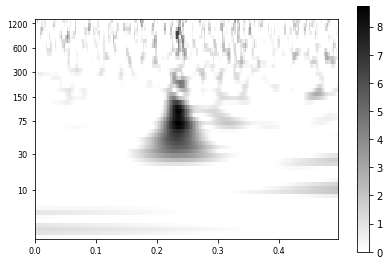

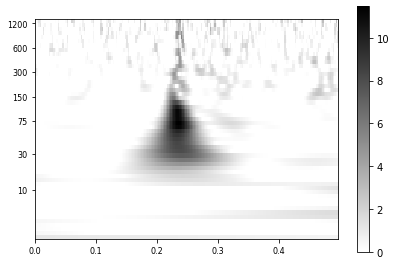

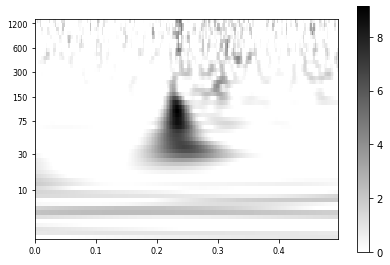

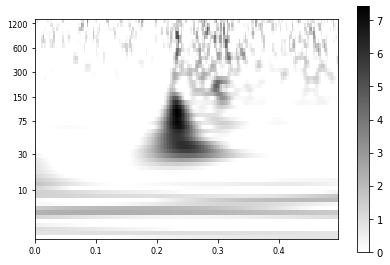

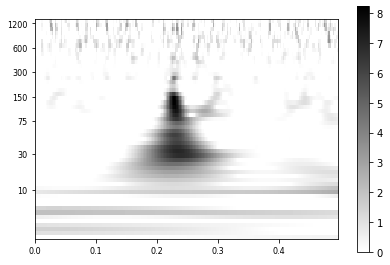

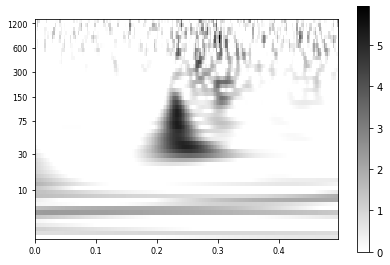

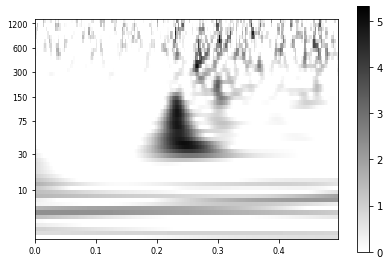

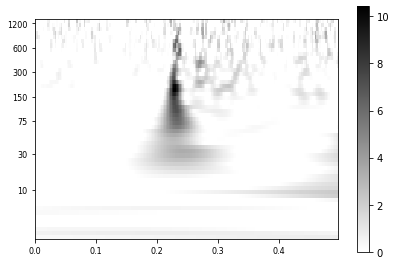

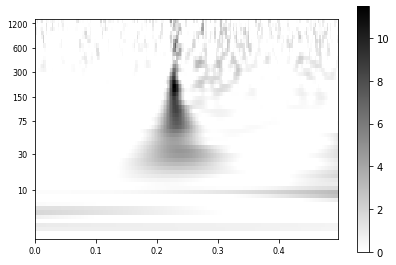

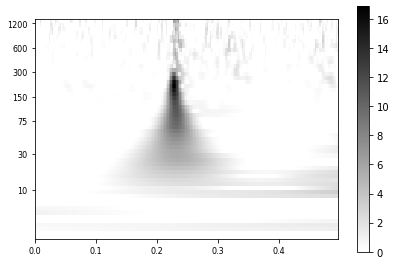

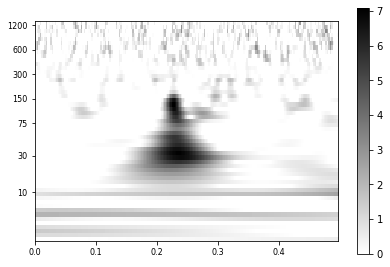

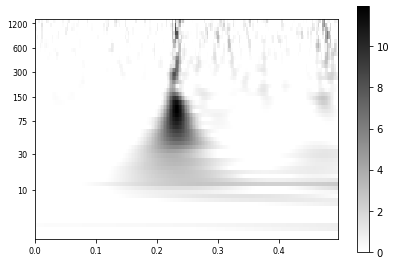

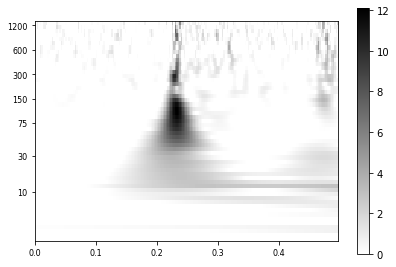

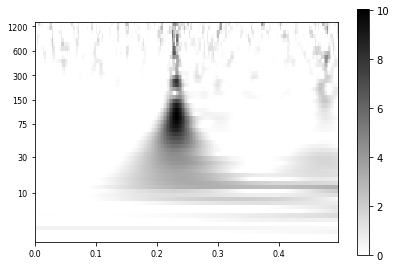

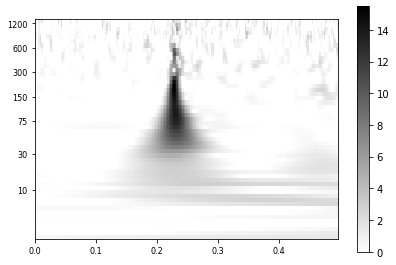

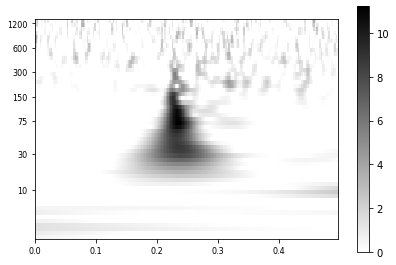

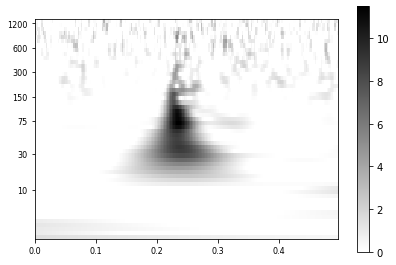

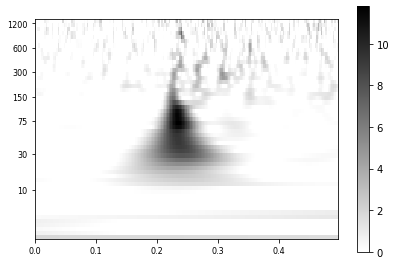

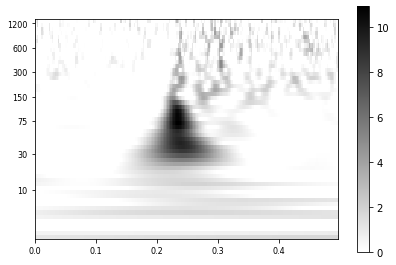

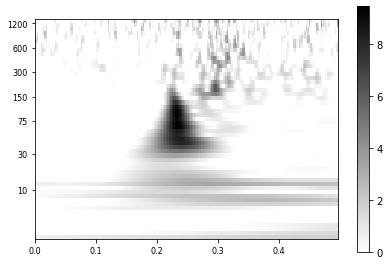

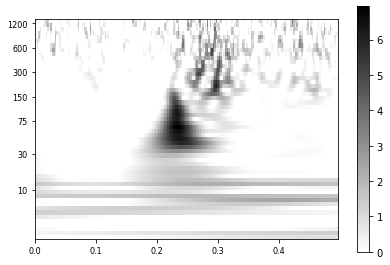

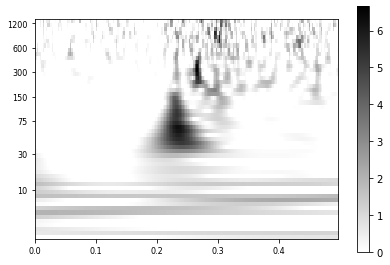

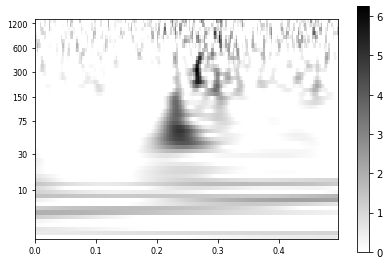

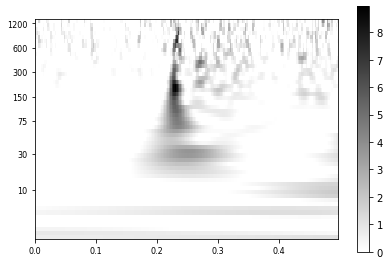

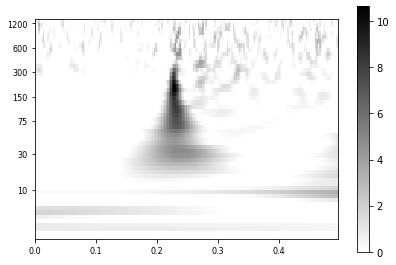

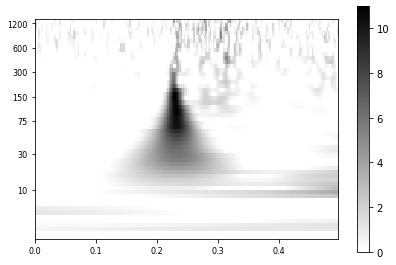

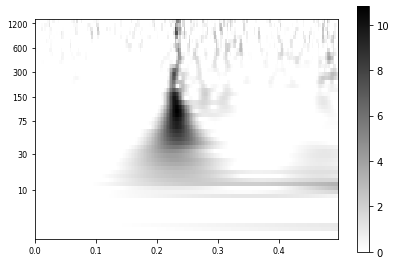

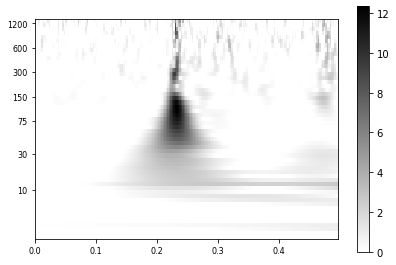

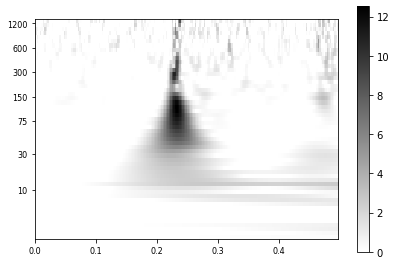

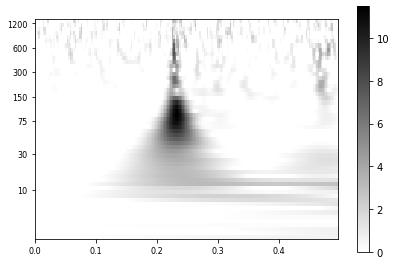

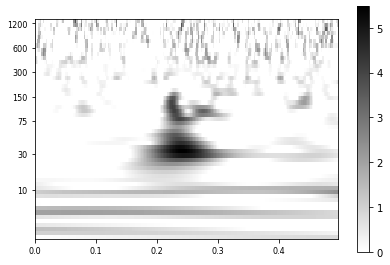

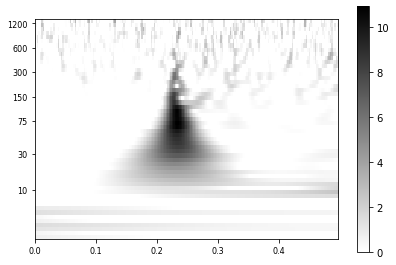

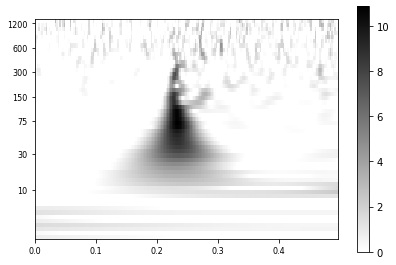

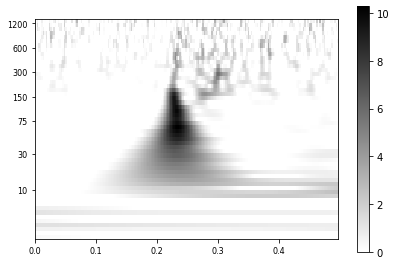

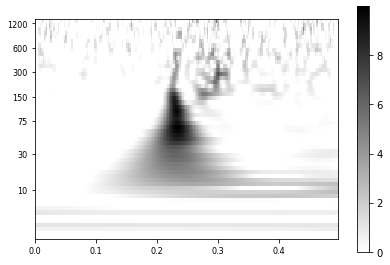

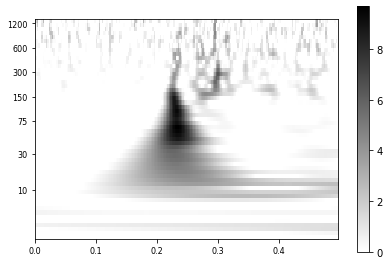

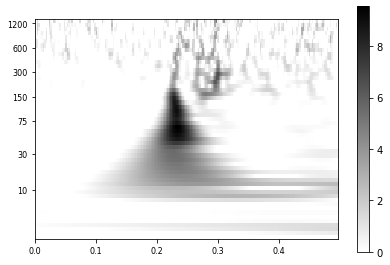

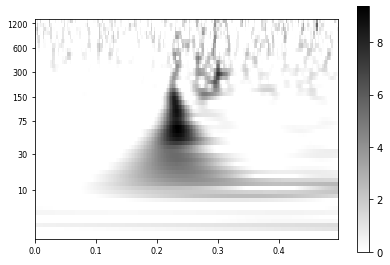

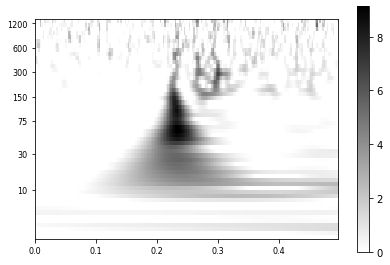

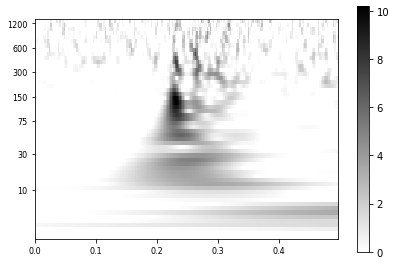

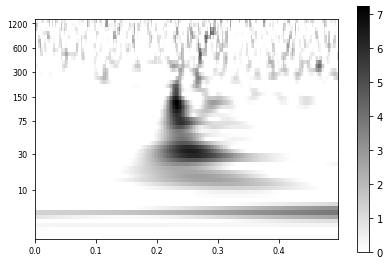

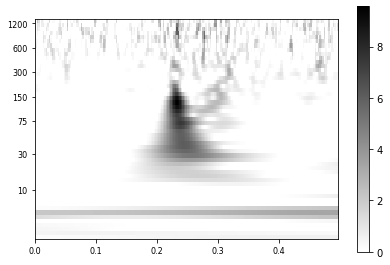

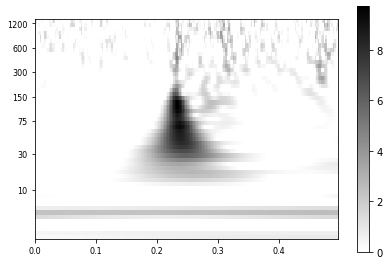

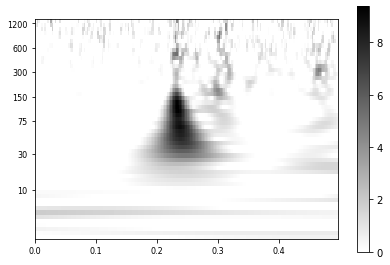

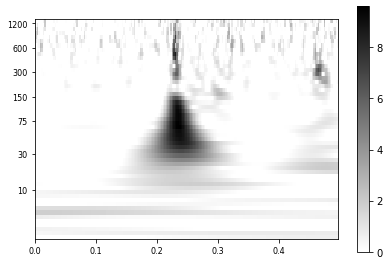

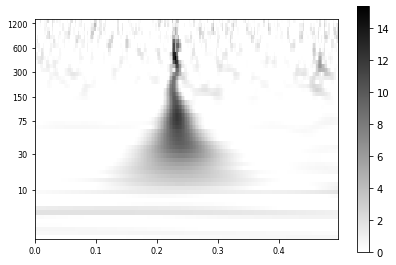

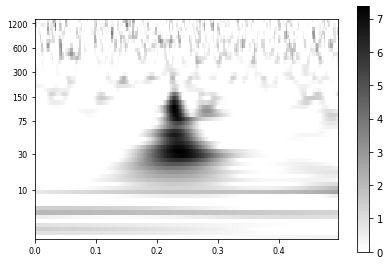

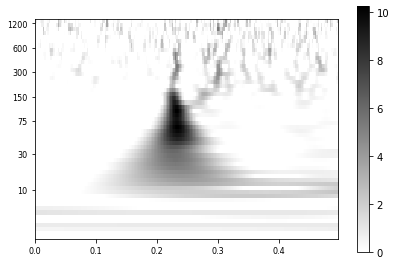

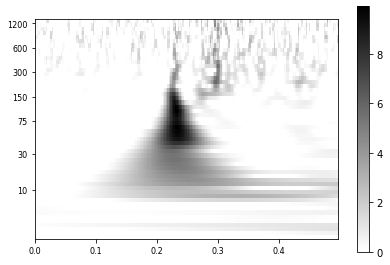

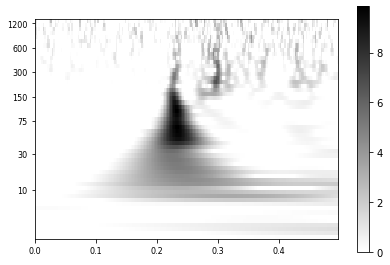

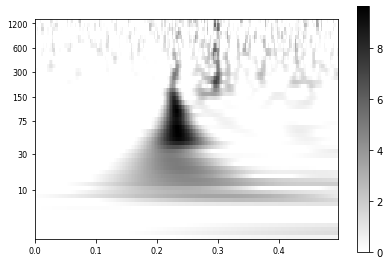

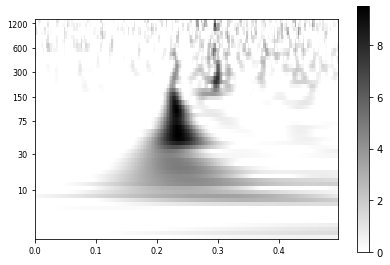

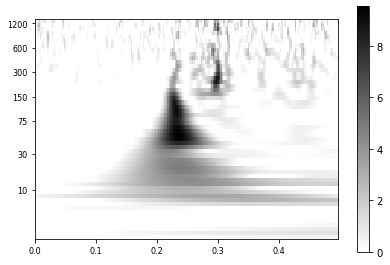

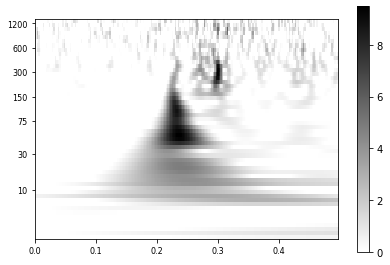

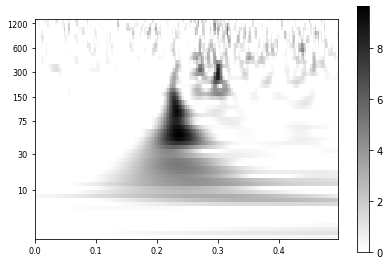

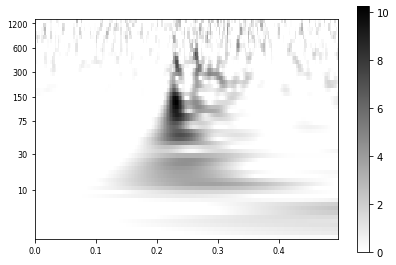

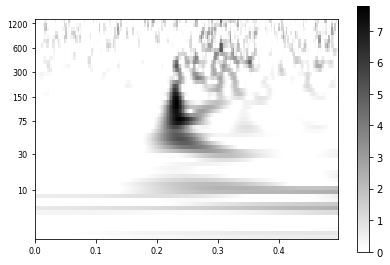

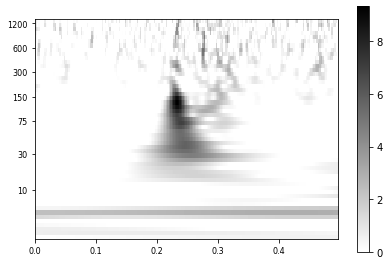

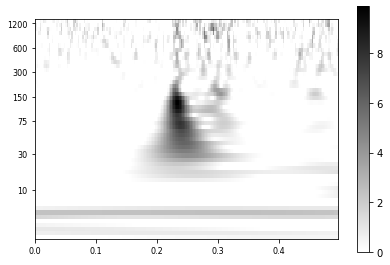

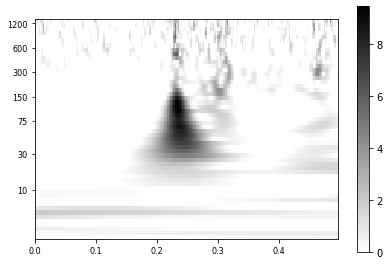

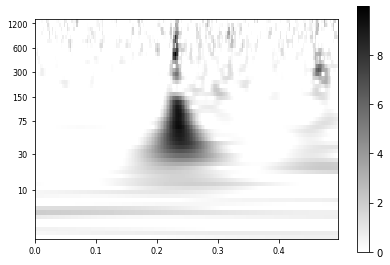

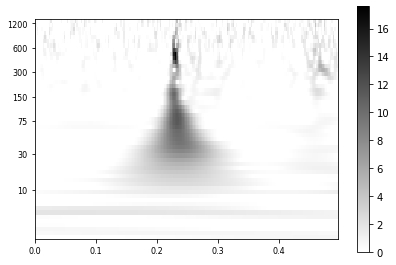

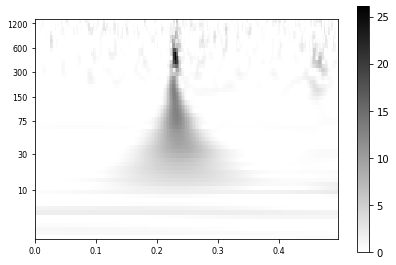

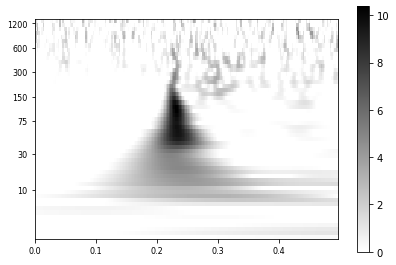

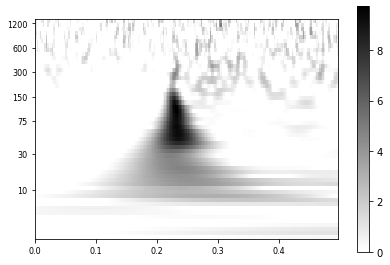

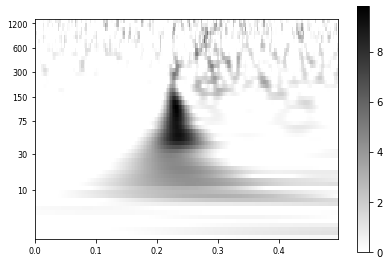

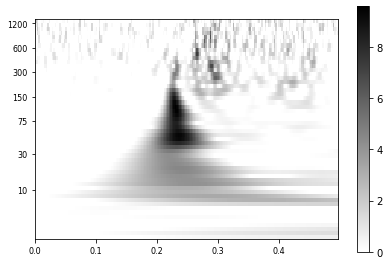

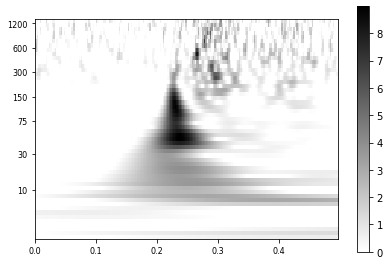

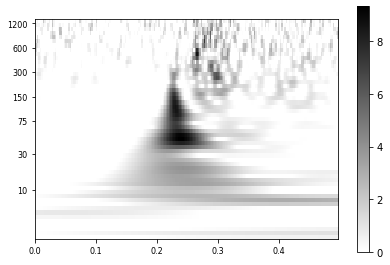

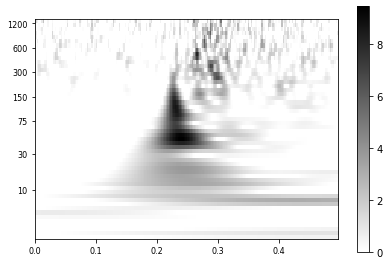

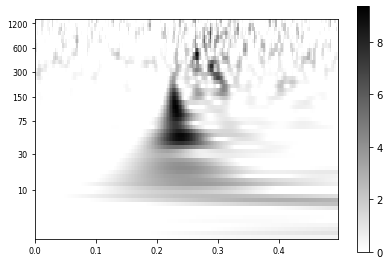

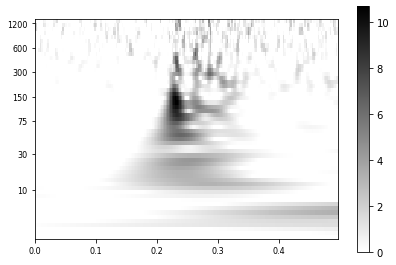

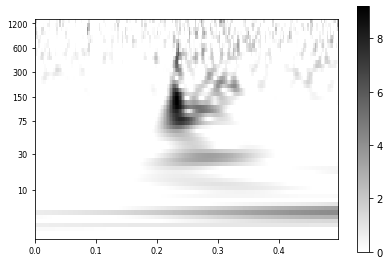

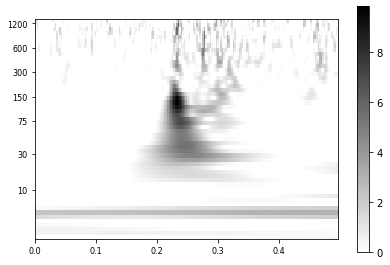

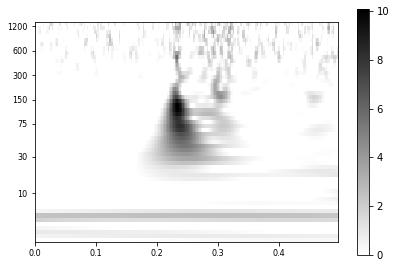

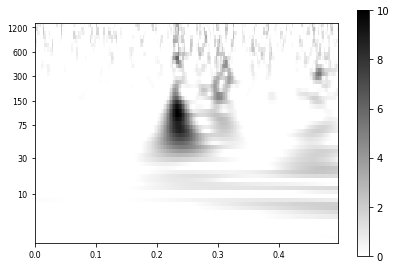

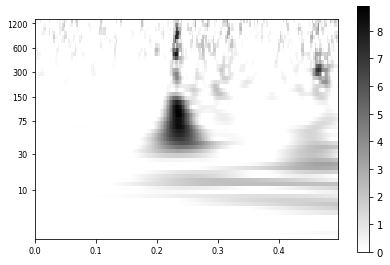

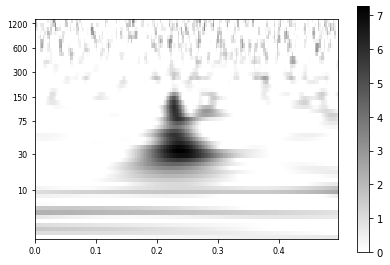

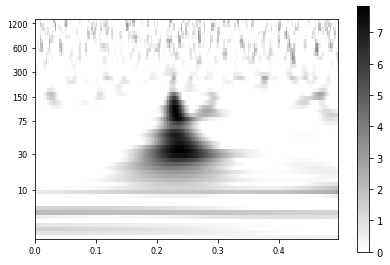

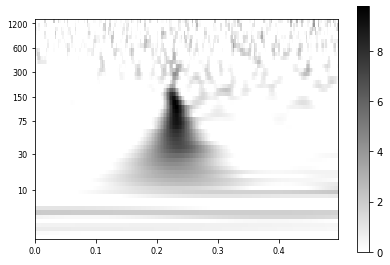

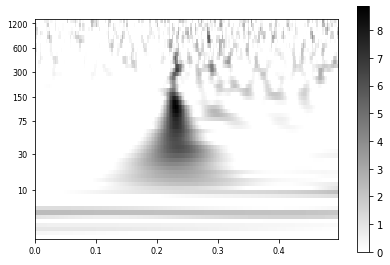

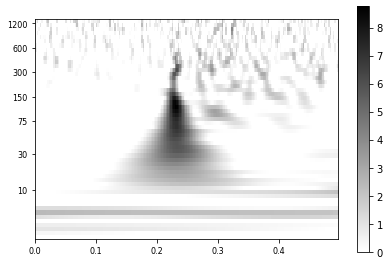

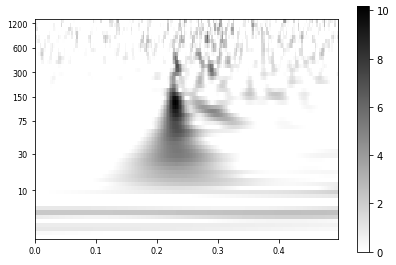

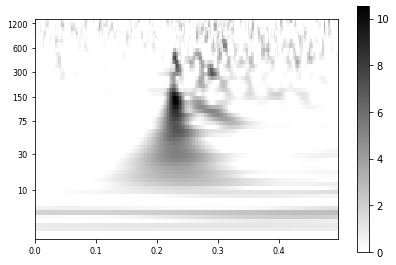

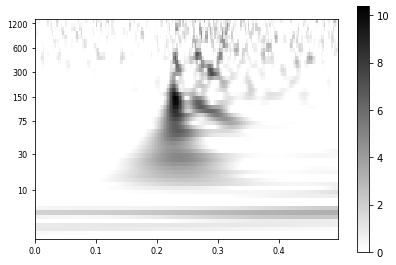

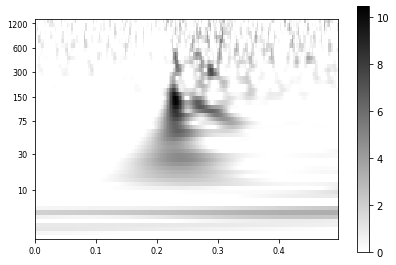

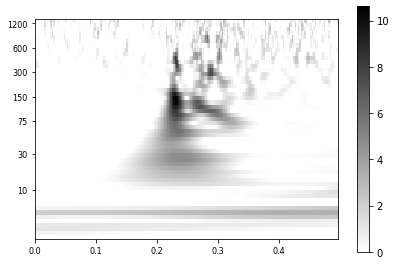

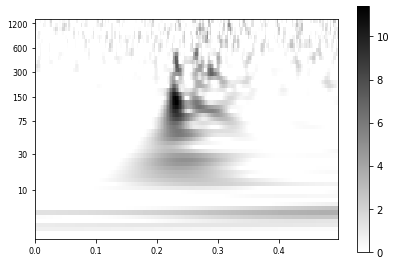

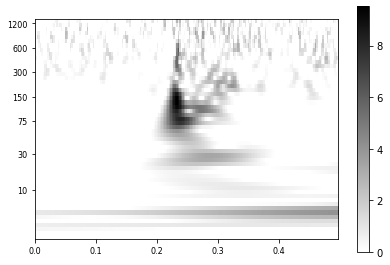

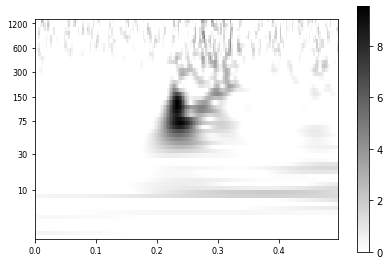

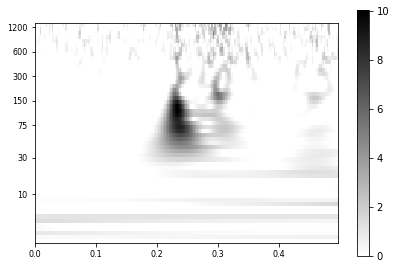

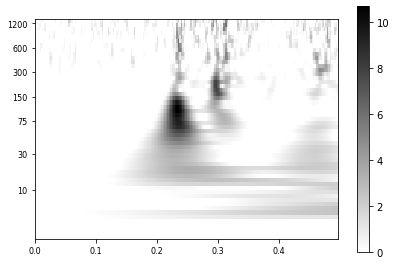

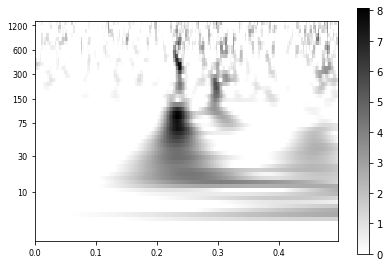

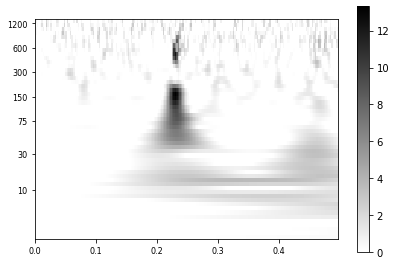

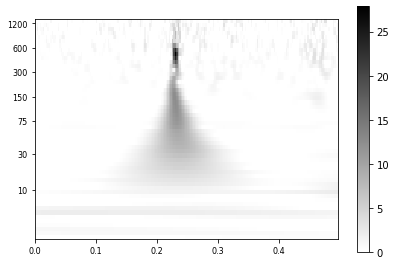

In [67]:
plot_spect_matrix(Wall, channel_order)

In [15]:
# ordered_data = utils.channel_orderer(data, channel_order)

In [16]:
# W = Wall[:, 100, :]
# tbeg = int(fs_final*3.50)+800 #14.35
# tend = tbeg + int(fs_final*.5)-800#0.5
# Wsnip = W[tbeg:tend, :]
# mean = np.mean(W, axis=0)
# sigma = np.std(W, axis=0)
# Wsnip_norm = (Wsnip - mean)/sigma
# t = np.arange(0, tend-tbeg)/fs_final
# fig, ax = spectral.plot_spectrogram(Wsnip_norm, np.array(f), t, colorbar=True)
# ax.set_xlabel('Time (sec)')
# ax.set_ylabel('Frequency (Hz)')

In [76]:
tbeg

11200

In [77]:
tend

12800

In [16]:
io.close()

In [5]:
io.close()  # remember to close!